In [1]:
import matplotlib.pyplot as plt
import numpy as np

import scripts.models.lstm_oneshot_multistep as lstm
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import train_model
from utils.plotting import (
    plot_all_data_results,
    plot_metric_results,
    plot_original_vs_processed_data,
)

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
###### Simulated data training #########

In [4]:
SEED = 42
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [5]:
EXP = "sim_b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,time
0,10.656969,16.801851,0.00
1,10.658275,16.802265,0.01
2,10.659582,16.802679,0.02
3,10.660889,16.803091,0.03
4,10.662196,16.803503,0.04


In [6]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20000,)

In [7]:
SMOOTHING_WINDOW = 1
DOWNSAMPLING_FACTOR = 2
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(10000,)

In [8]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.003897796975239095,
  'p_value': 0.9968900417656372,
  'significant': False},
 'variance_comparison': {'f_statistic': 1.5192821265099376e-05,
  'p_value': 0.9968900419003165,
  'significant': False}}

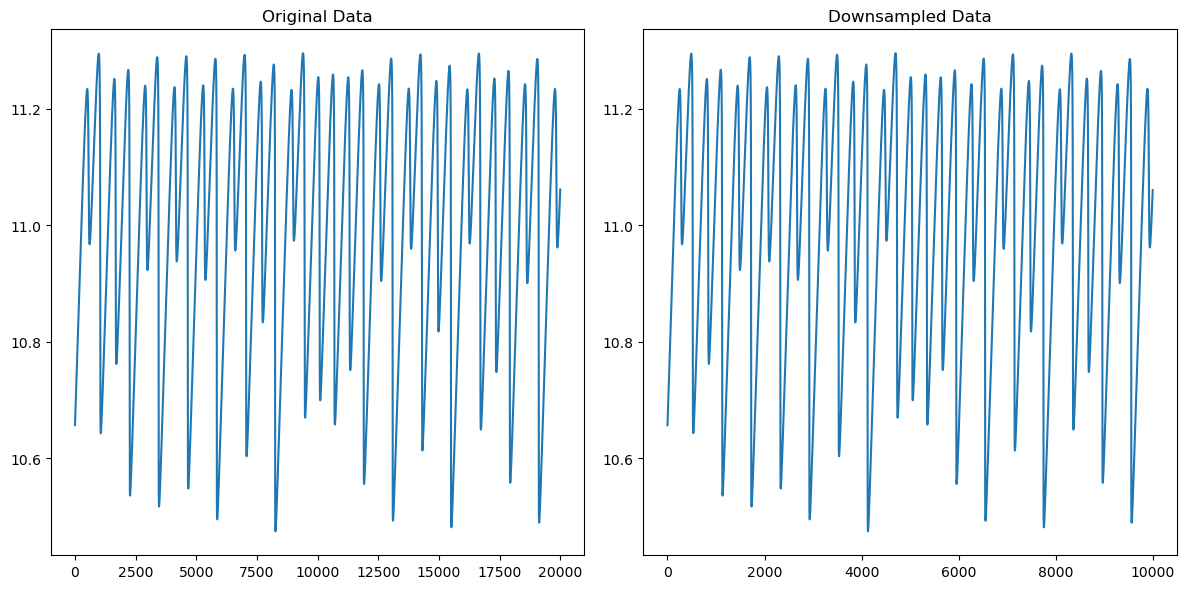

In [9]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

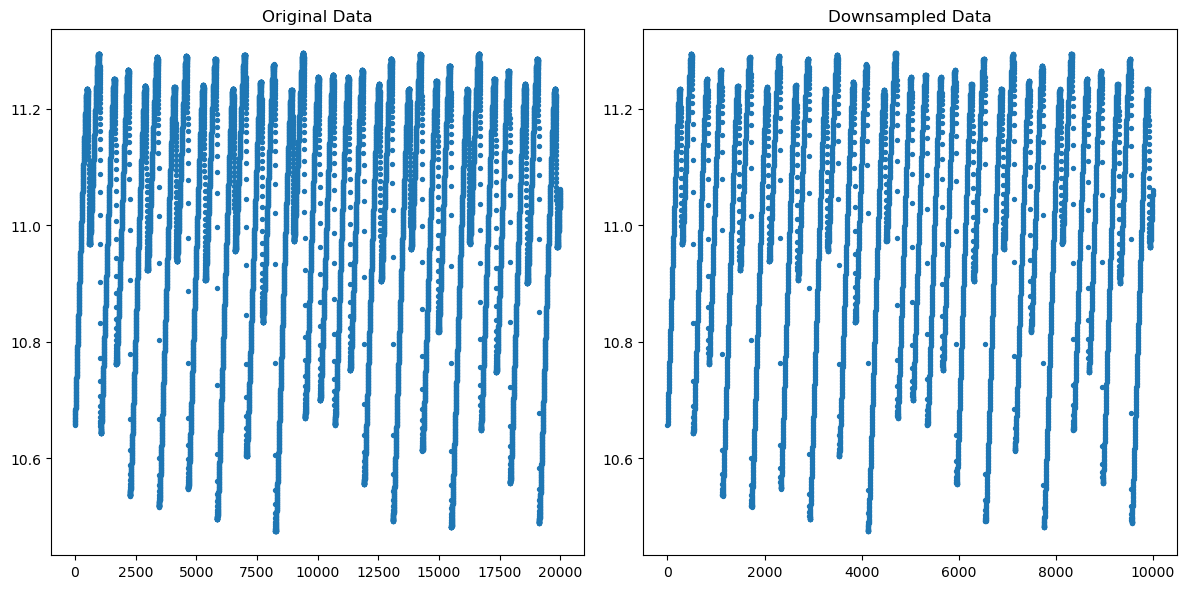

In [10]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "scatter", "Downsampled"
)

In [11]:
LOOKBACK, FORECAST = 300, 30
N_FORECAST_WINDOWS = 15

X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([9671, 300]), torch.Size([9671, 30])


In [12]:
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([9210, 300]), torch.Size([9210, 30])
Testing data shapes: torch.Size([450, 300]), torch.Size([450, 30])


In [13]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])

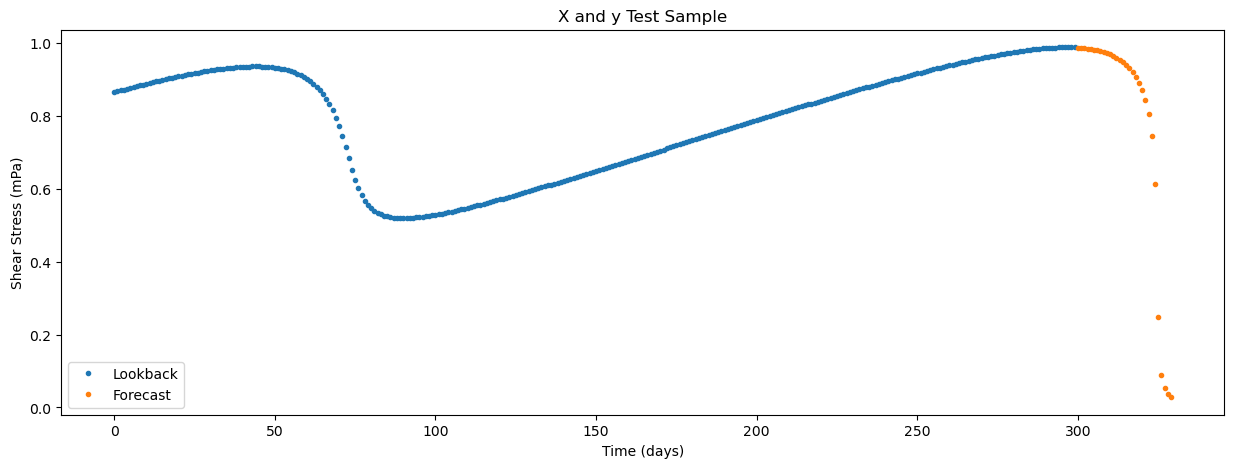

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10],
    ".",
    label="Forecast",
)
plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Shear Stress (mPa)")
plt.legend()
plt.show()

In [15]:
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLSTMMultiLayer(
    N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
).to(device)

In [16]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.0277, Test RMSE: 0.0332: 100%|██████| 100/100 [02:24<00:00,  1.44s/it]


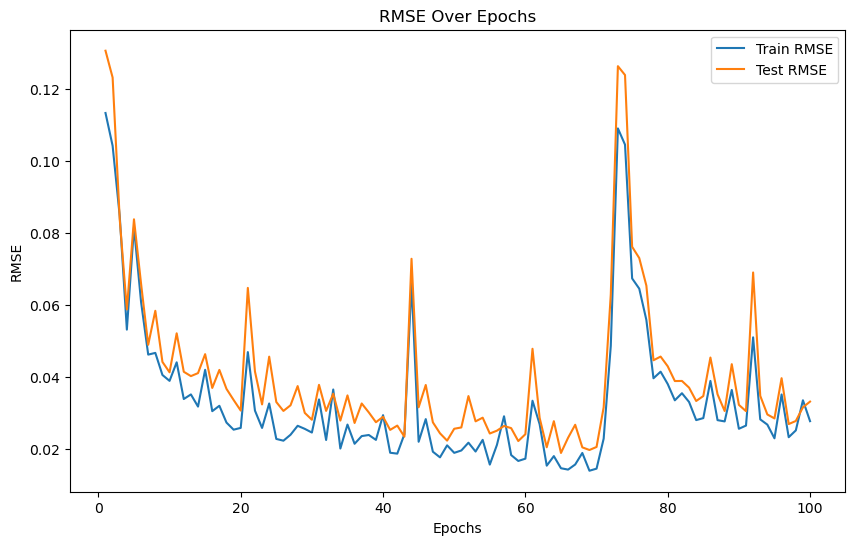

In [17]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

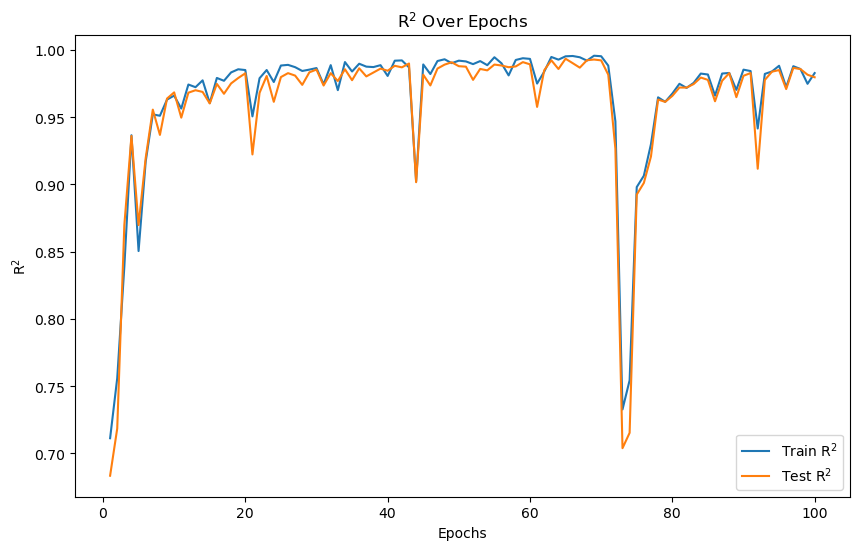

In [18]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [19]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Shear Stress (mPa)"

ZOOM_MIN = 9010
ZOOM_MAX = 9500
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

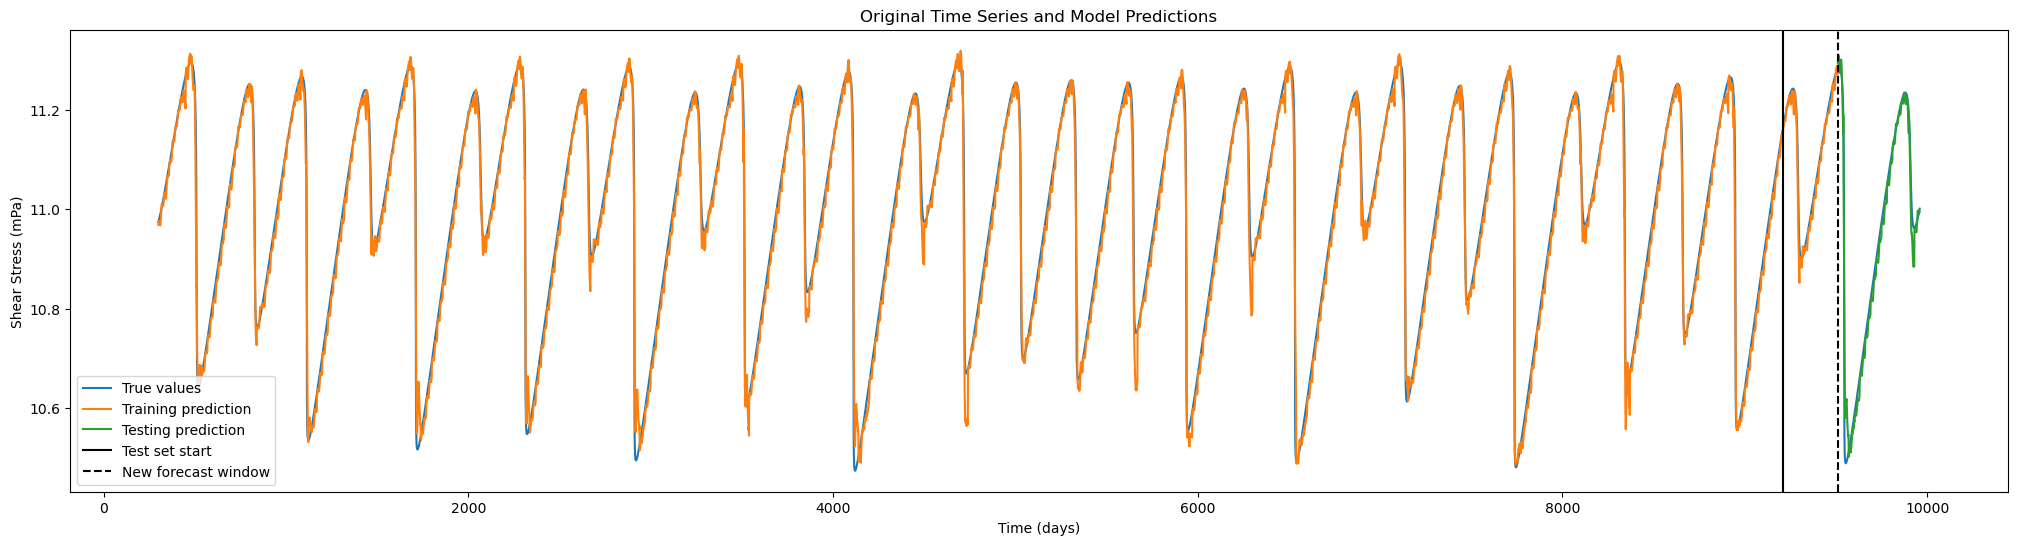

In [20]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

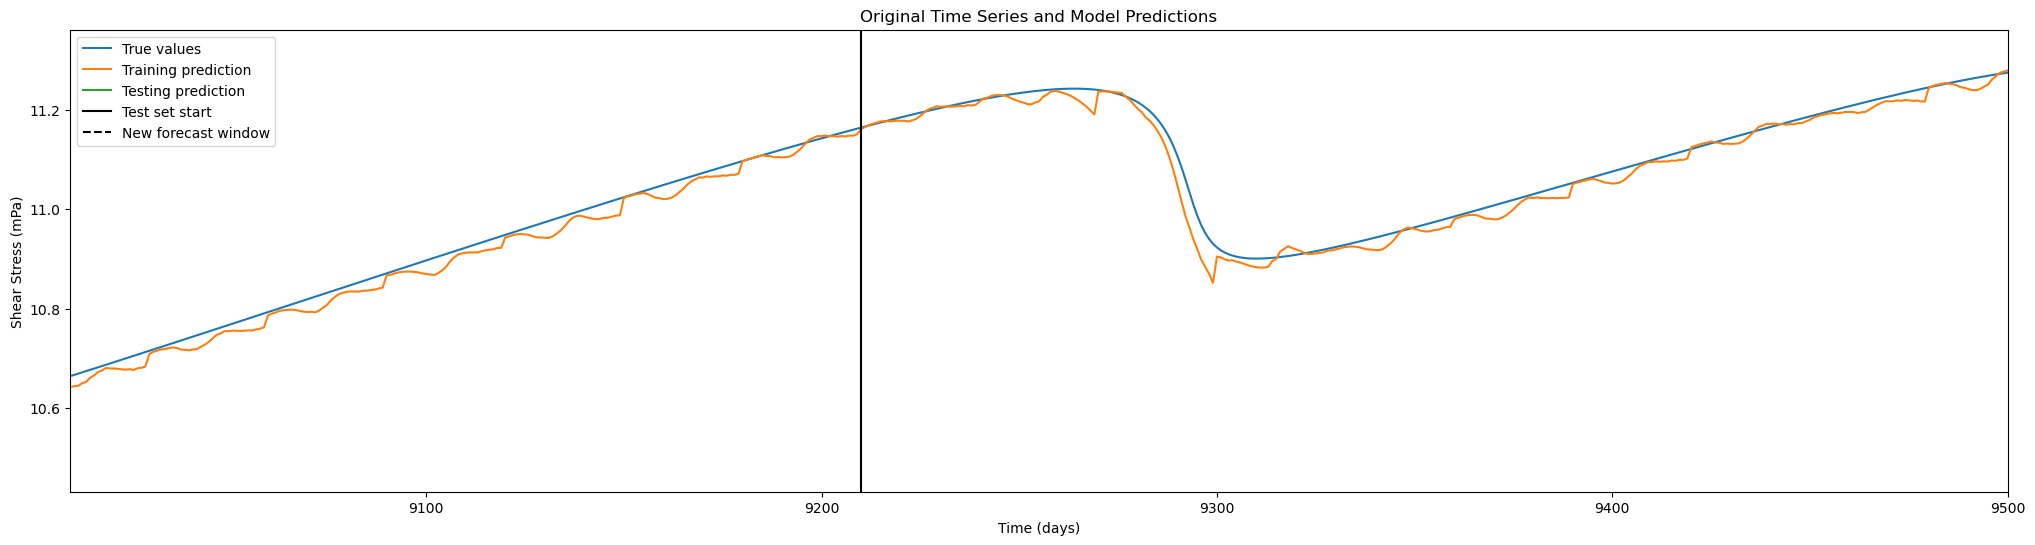

In [21]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)

In [22]:
###### Lab data training #########

In [23]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [24]:
EXP = "b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,11.225116,17.382861,20.088637,22.167371,0.00
1,11.222870,17.375571,20.088683,22.167447,0.01
2,11.224972,17.385328,20.088975,22.167941,0.02
3,11.221124,17.373017,20.088549,22.167221,0.03
4,11.225461,17.386512,20.089116,22.168180,0.04


In [25]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20001,)

In [26]:
SMOOTHING_WINDOW = 1
DOWNSAMPLING_FACTOR = 2
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(10001,)

In [27]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.01129208583655751,
  'p_value': 0.9909904856087365,
  'significant': False},
 'variance_comparison': {'f_statistic': 0.00012751120251926028,
  'p_value': 0.9909904856229135,
  'significant': False}}

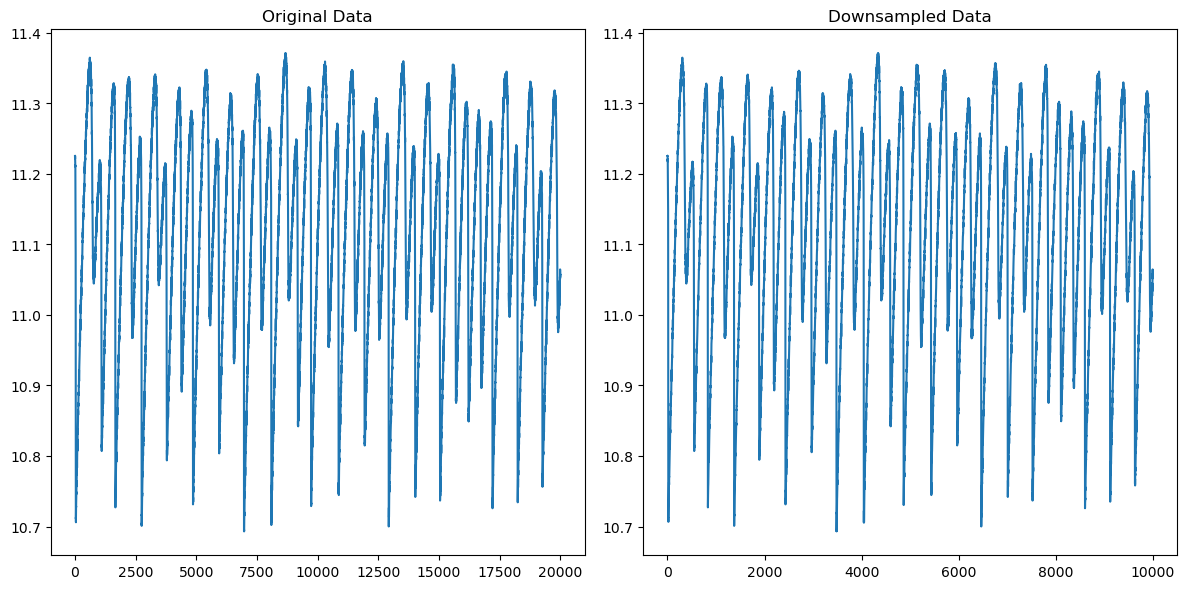

In [28]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

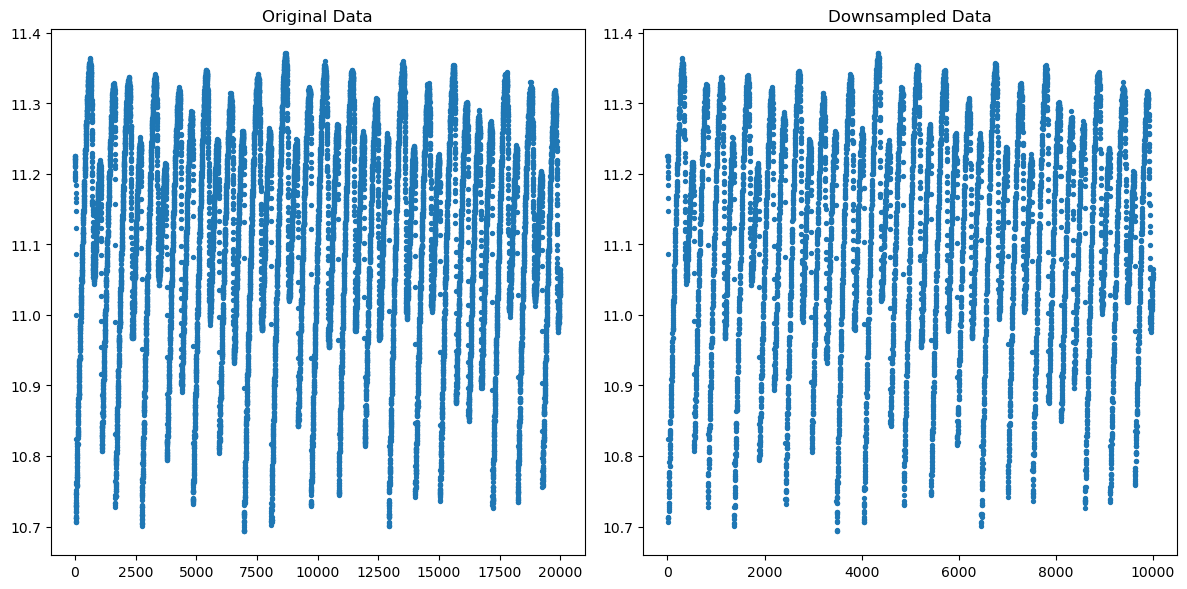

In [29]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "scatter", "Downsampled"
)

In [30]:
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([9672, 300]), torch.Size([9672, 30])


In [31]:
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([9210, 300]), torch.Size([9210, 30])
Testing data shapes: torch.Size([450, 300]), torch.Size([450, 30])


In [32]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])

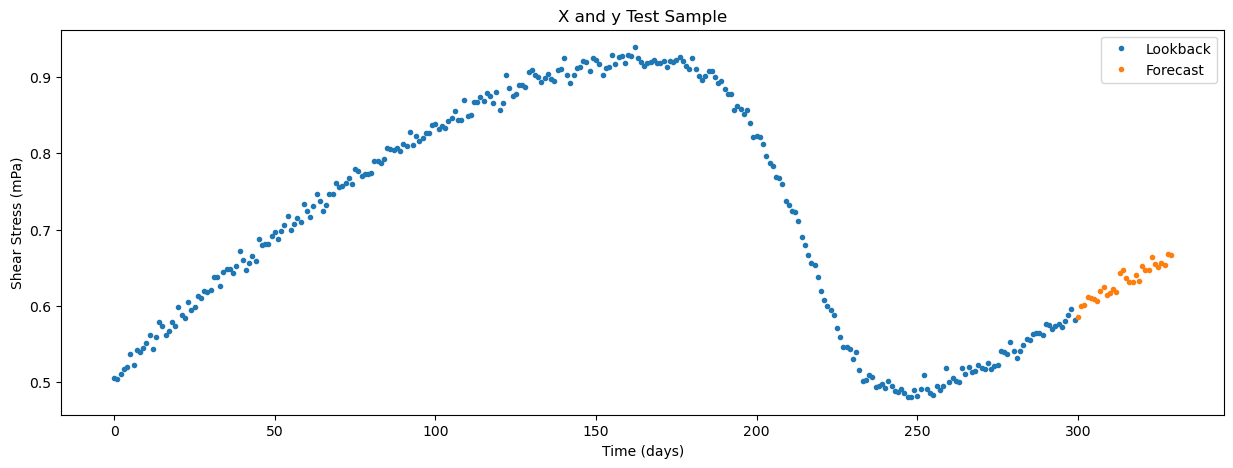

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10],
    ".",
    label="Forecast",
)
plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Shear Stress (mPa)")
plt.legend()
plt.show()

In [34]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.0318, Test RMSE: 0.0452: 100%|██████| 100/100 [02:58<00:00,  1.79s/it]


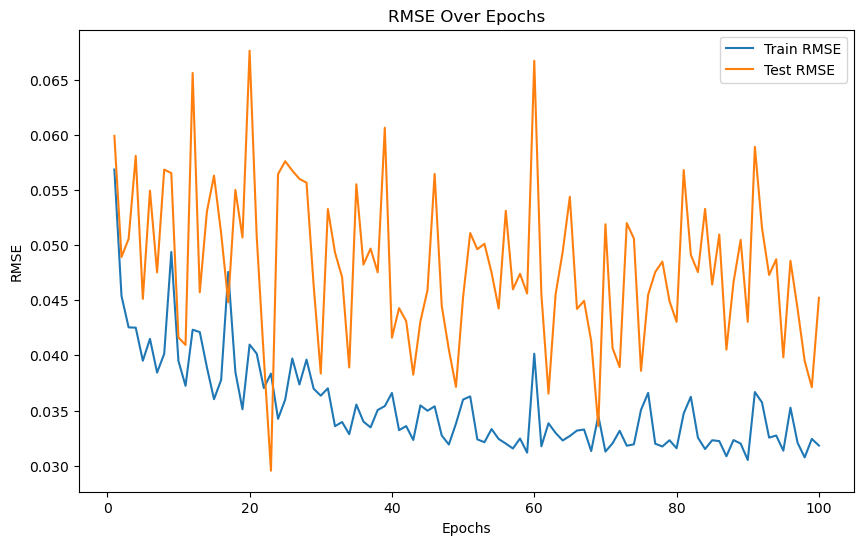

In [35]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

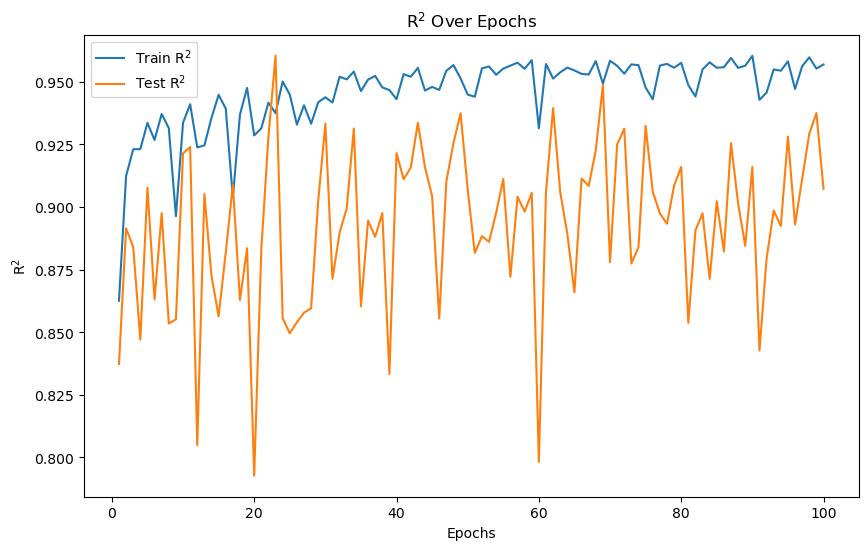

In [36]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [37]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Shear Stress (mPa)"

ZOOM_MIN = 9010
ZOOM_MAX = 9500
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

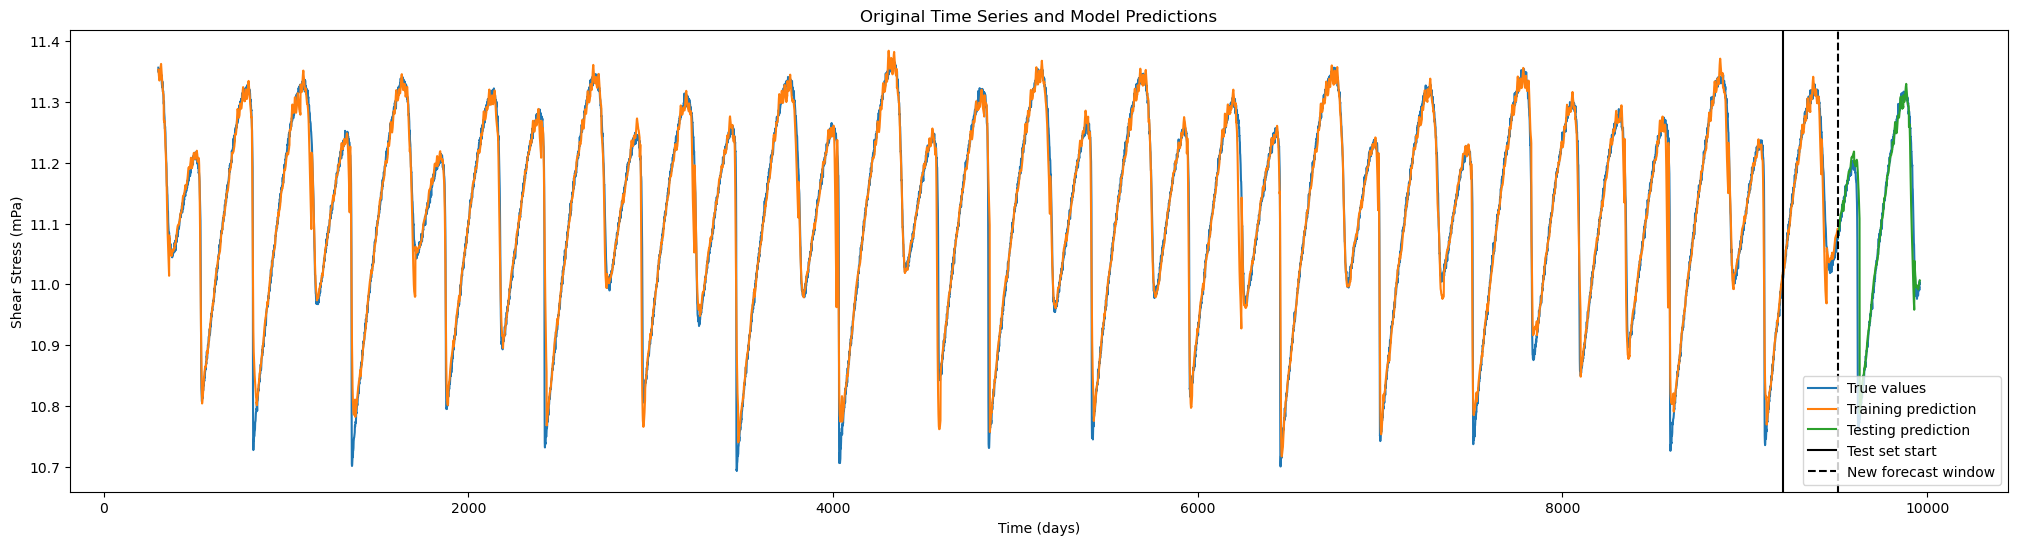

In [38]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

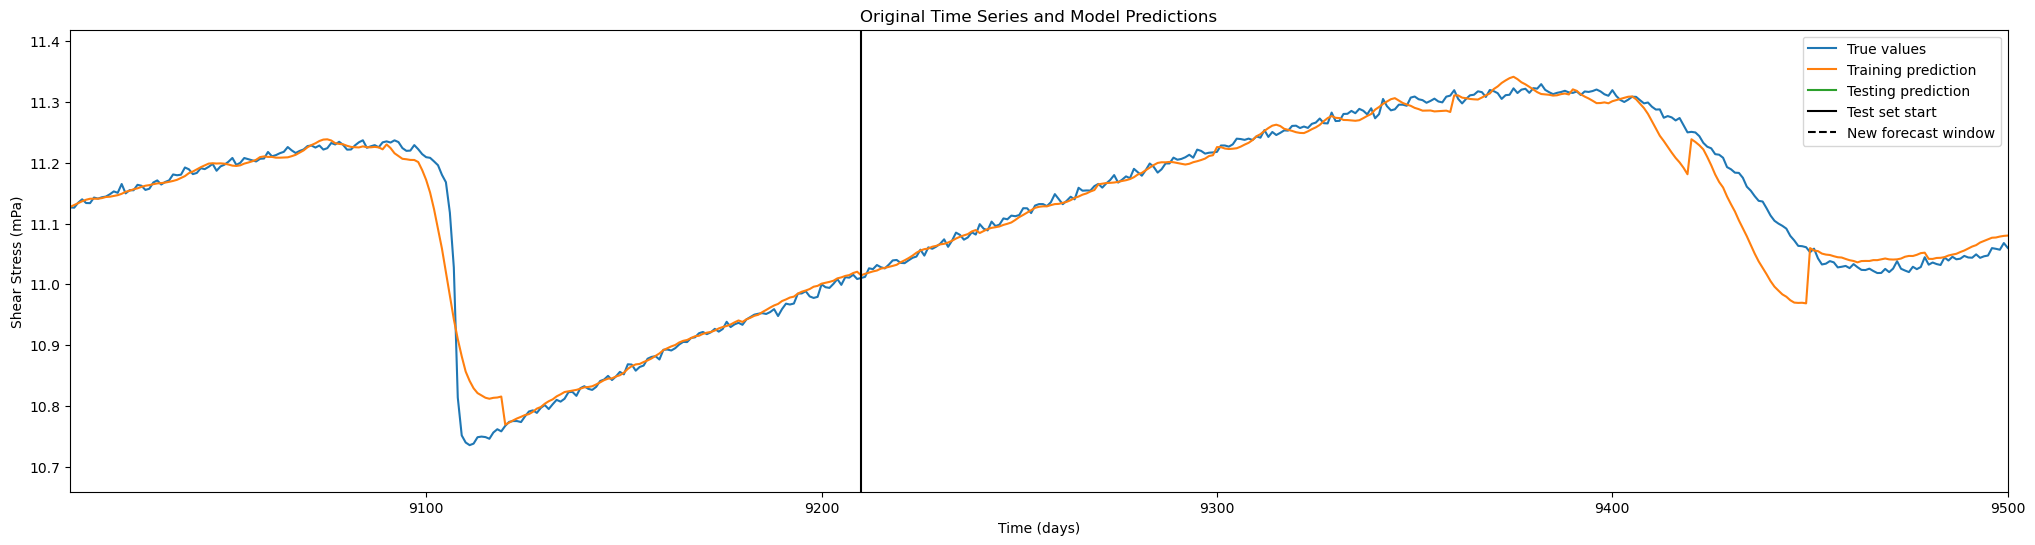

In [39]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)

In [40]:
###### Cascadia data training #########

In [41]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [42]:
EXP = "cascadia"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [43]:
segment_df = df["seg_avg"] / 1e8
segment_df.shape

(3883,)

In [44]:
SMOOTHING_WINDOW = 10
DOWNSAMPLING_FACTOR = 1
df_smoothed = moving_average_causal_filter(
    segment_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(3874,)

In [45]:
results = compare_feature_statistics(segment_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.048536835802983076,
  'p_value': 0.961289658191594,
  'significant': False},
 'variance_comparison': {'f_statistic': 0.002355824429765806,
  'p_value': 0.9612896581873488,
  'significant': False}}

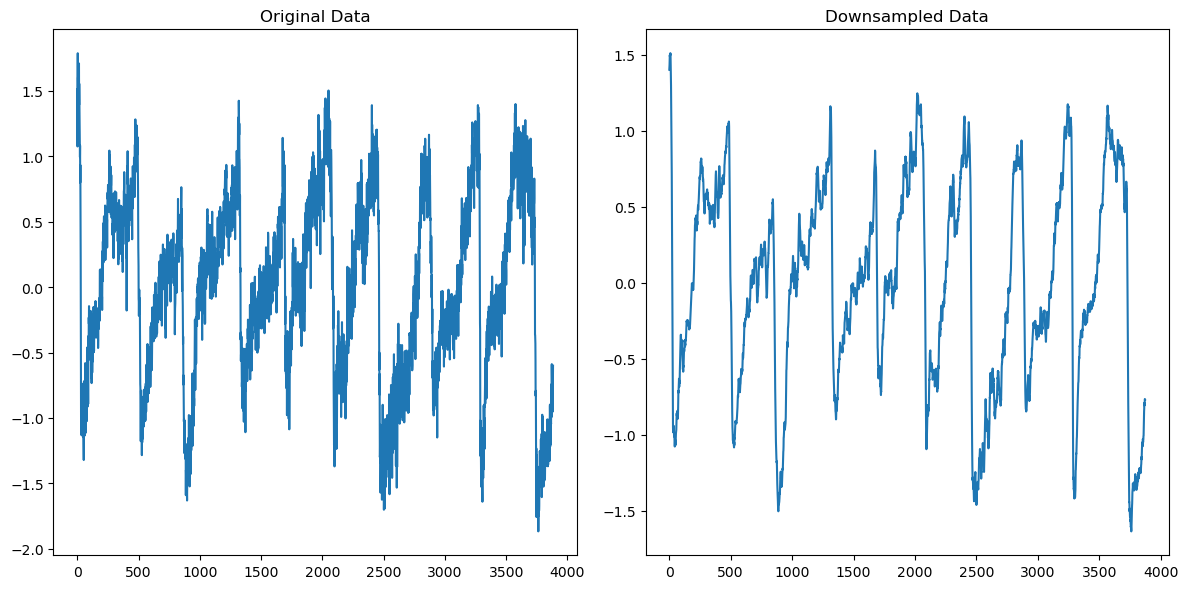

In [46]:
plot_original_vs_processed_data(segment_df, df_smoothed, "line", "Downsampled")

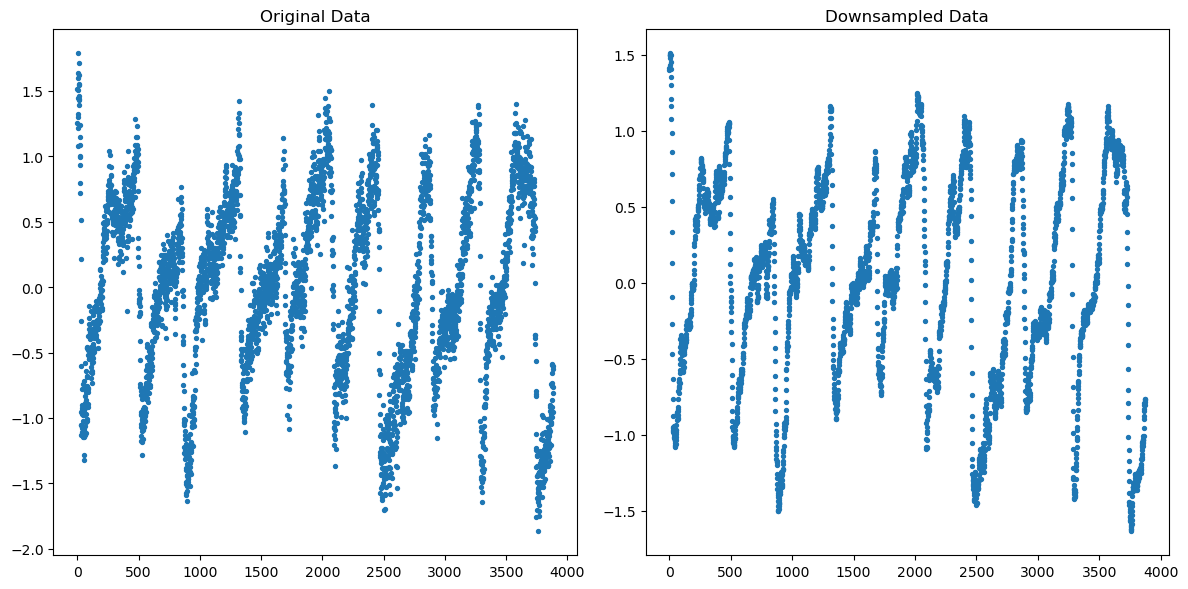

In [47]:
plot_original_vs_processed_data(
    segment_df, df_smoothed, "scatter", "Downsampled"
)

In [48]:
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3545, 300]), torch.Size([3545, 30])


In [49]:
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([3090, 300]), torch.Size([3090, 30])
Testing data shapes: torch.Size([450, 300]), torch.Size([450, 30])


In [50]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])

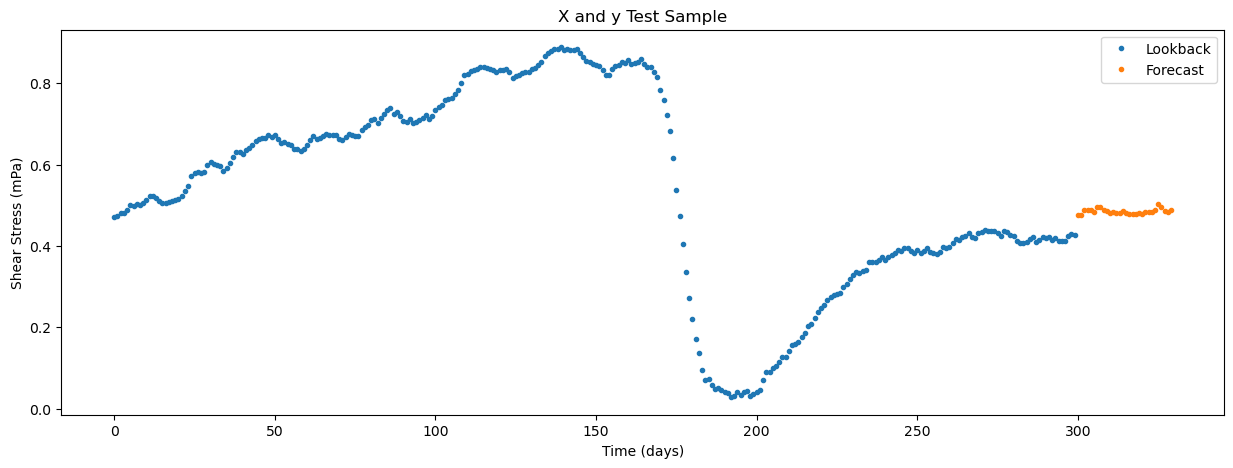

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10],
    ".",
    label="Forecast",
)
plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Shear Stress (mPa)")
plt.legend()
plt.show()

In [52]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.1723, Test RMSE: 0.6709: 100%|██████| 100/100 [01:22<00:00,  1.22it/s]


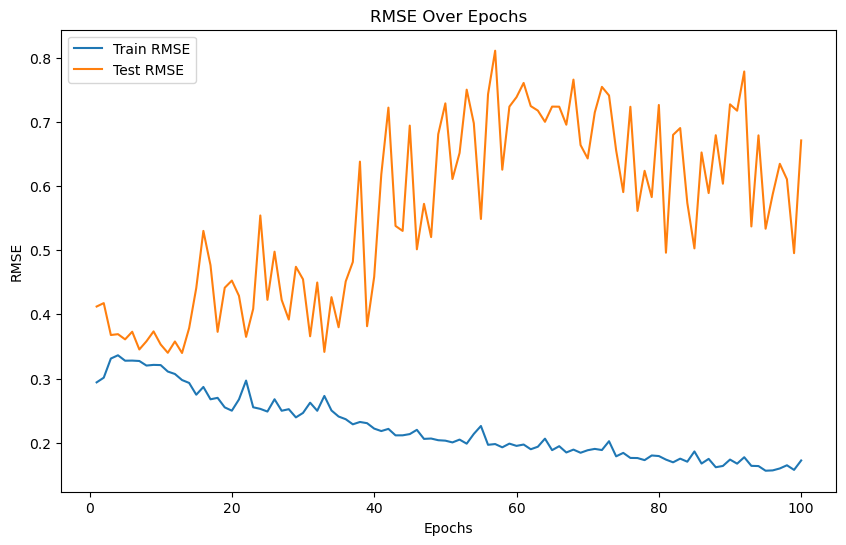

In [53]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

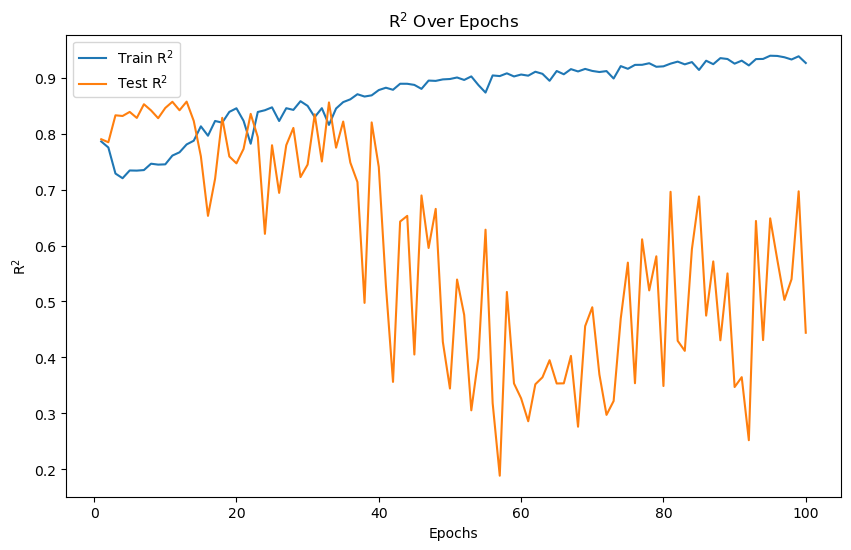

In [54]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [55]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Slip Displacement Potency ($m^3$)"

ZOOM_MIN = 3200
ZOOM_MAX = 4000
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

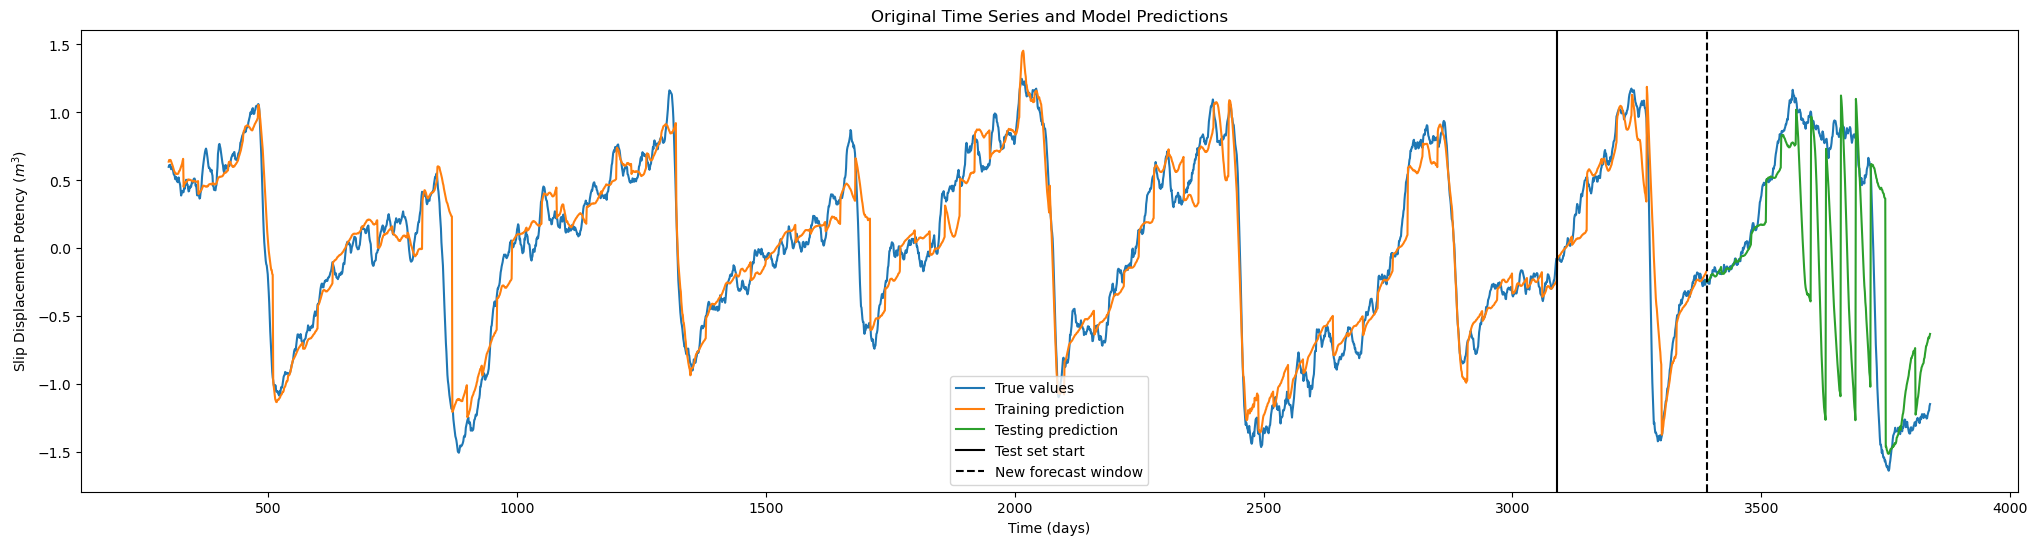

In [56]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

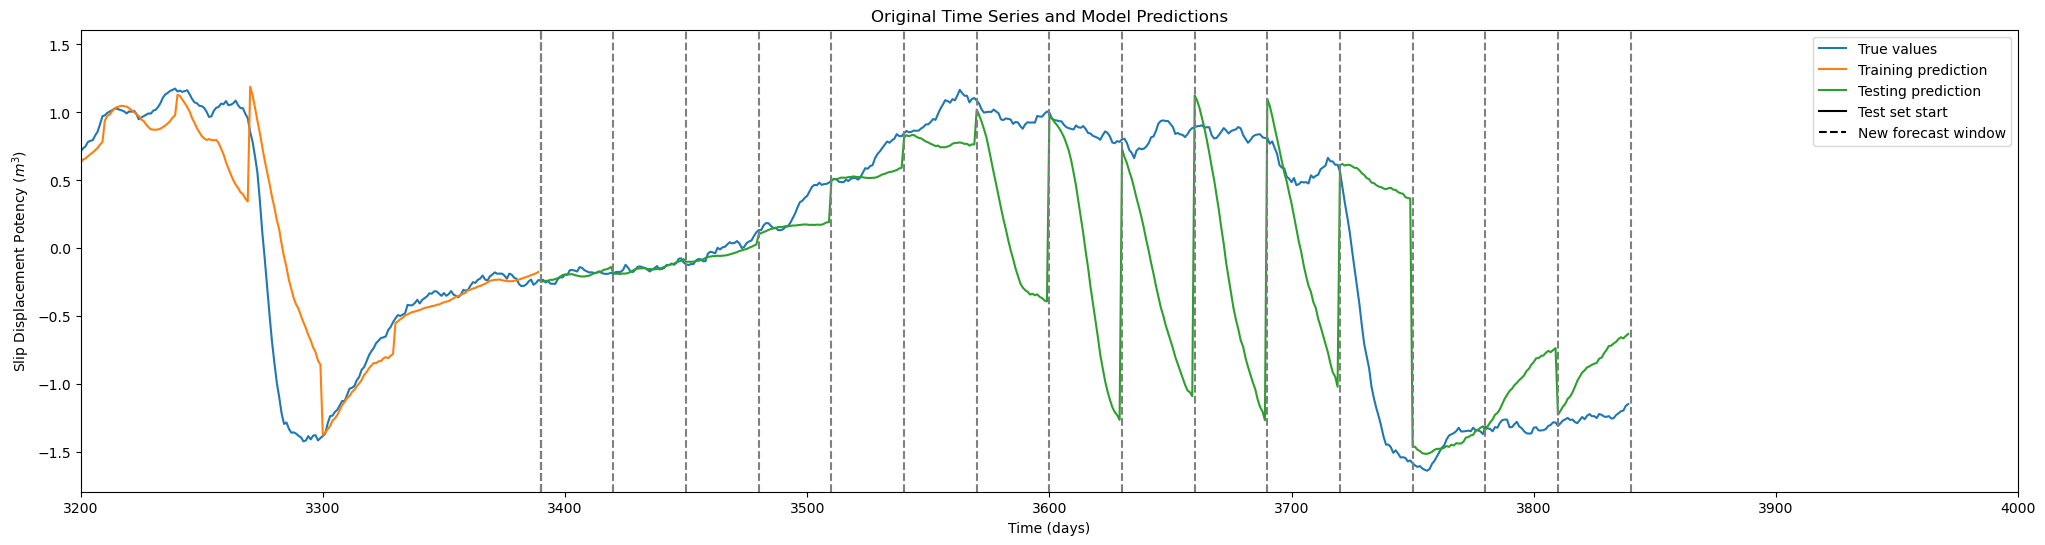

In [57]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)

In [58]:
###### Regular Cascadia data training #########

In [59]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [60]:
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLSTMMultiLayer(
    N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
).to(device)

In [61]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.2313, Test RMSE: 0.5178: 100%|██████| 100/100 [01:15<00:00,  1.33it/s]


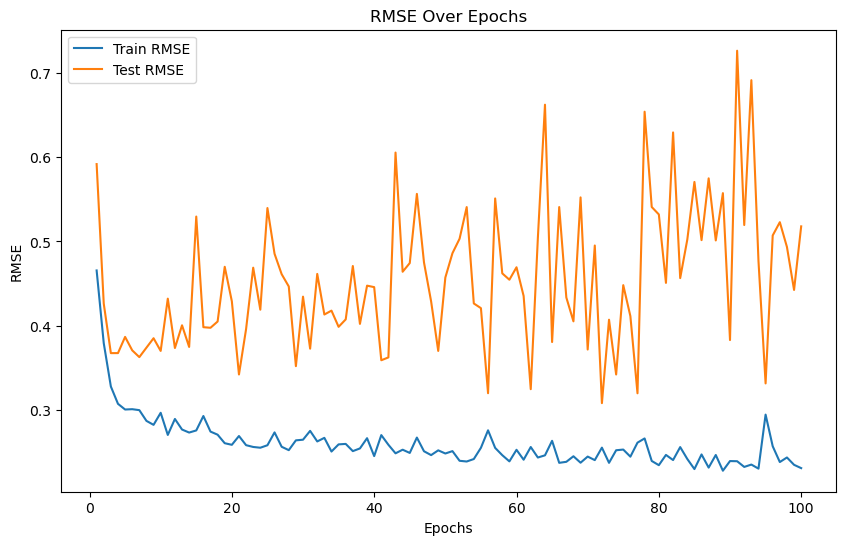

In [62]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

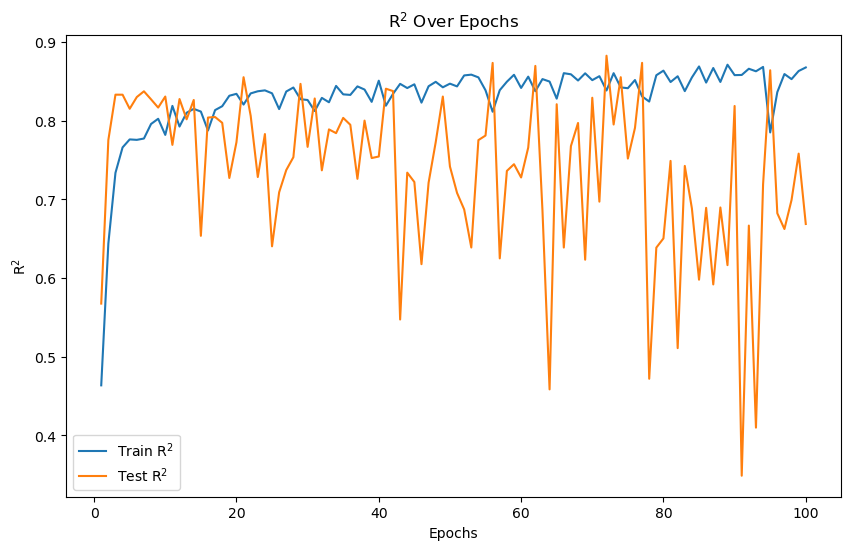

In [63]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [64]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Slip Displacement Potency ($m^3$)"

ZOOM_MIN = 3200
ZOOM_MAX = 4000
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

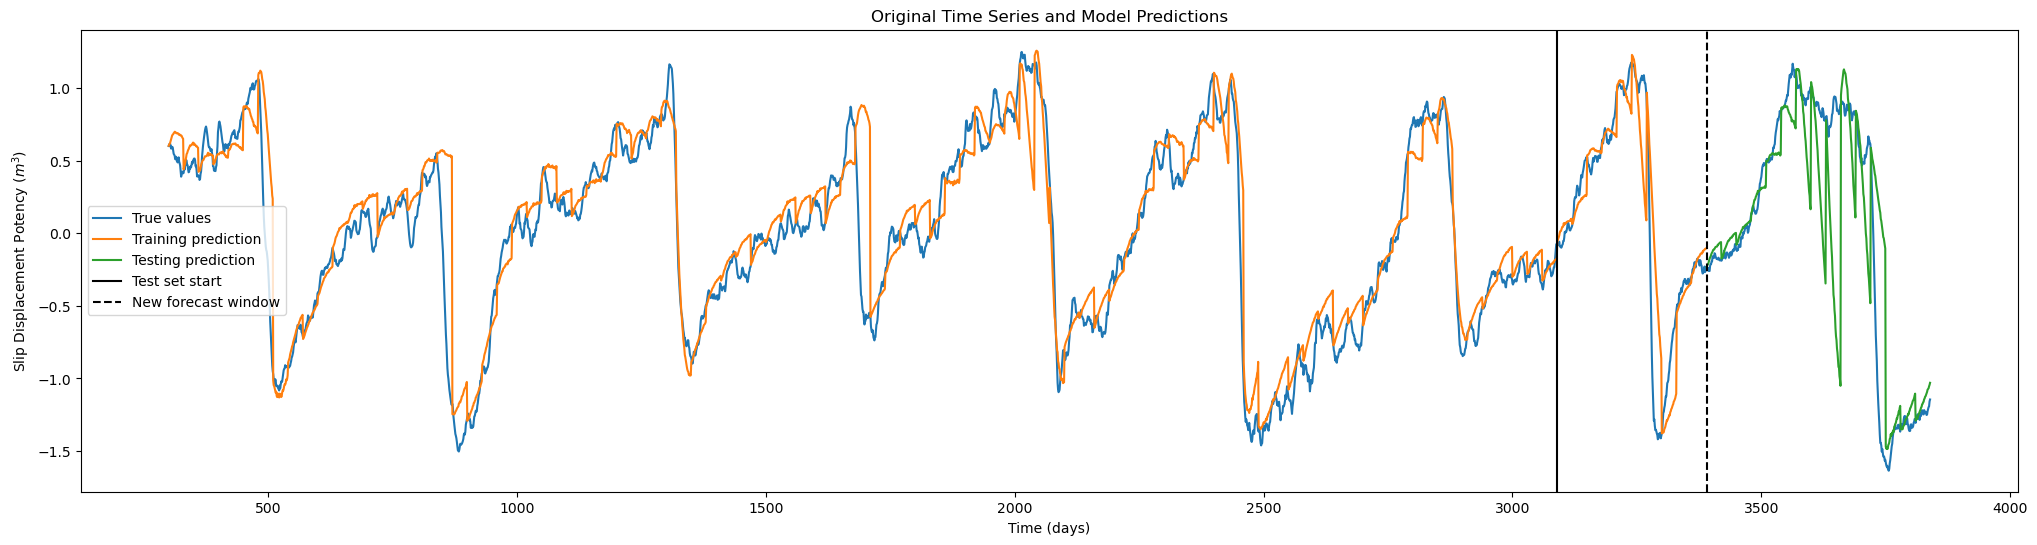

In [65]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

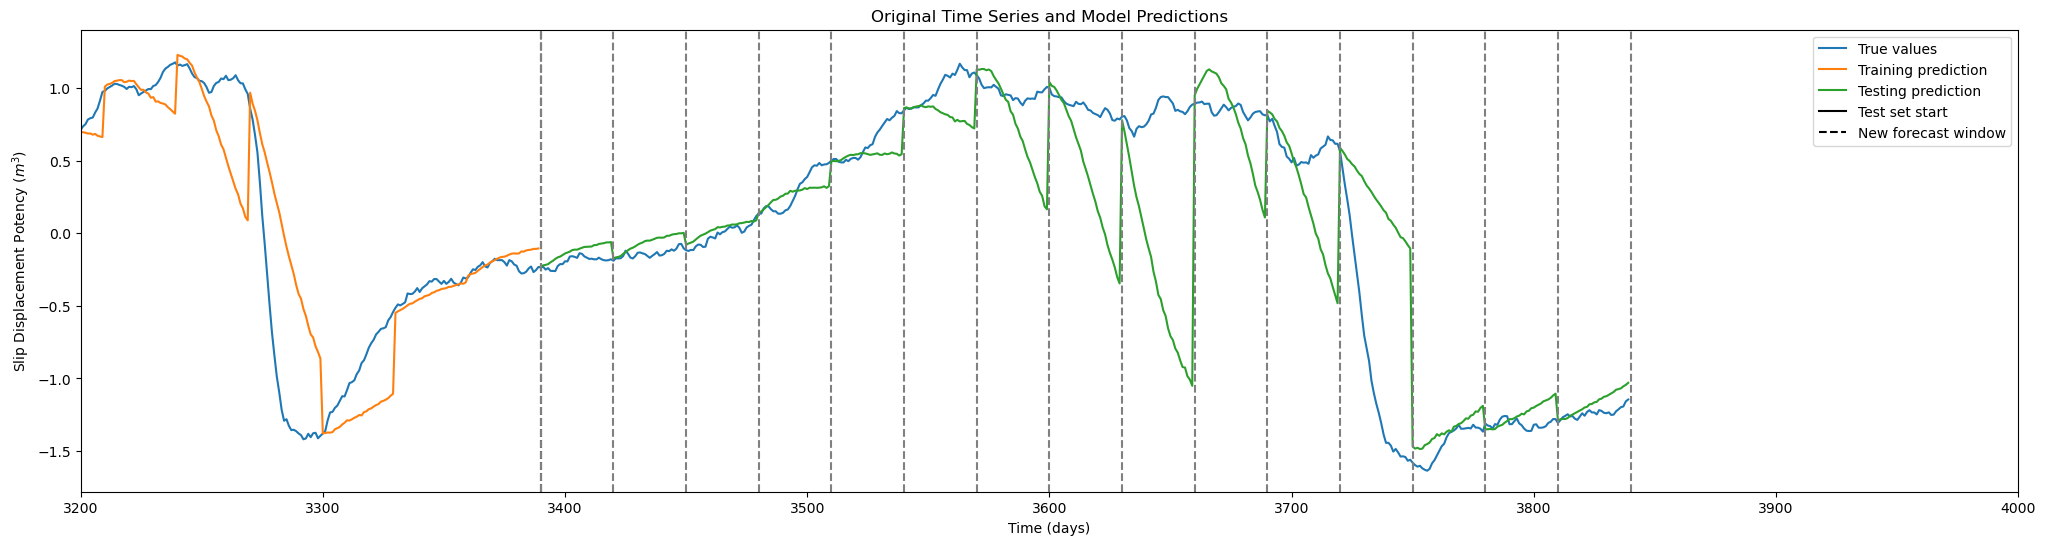

In [66]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)